In [14]:
import ast
import kenlm
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import sentencepiece
import string
import swifter

from datasets import load_dataset, load_from_disk, DatasetDict
from huggingface_hub import HfApi
from tqdm import tqdm

In [15]:
text_length_cutoff = 25000
perplexity_cutoff = 5000


def get_perplexity(meta):
    if isinstance(meta, str):
        meta = ast.literal_eval(meta)
    return int(meta["perplexity_score"])


def get_datasets():
    """
    ola_datasets = [
        ds_info.id
        for ds_info in HfApi().list_datasets(
            use_auth_token=os.environ.get("HUGGINGFACE_TOKEN")
        )
        if (
            ds_info.id.startswith("ola13/small-")
            and not ds_info.id.startswith("ola13/small-roots")
        )
        or ds_info.id == "ola13/small-roots_en"
    ]
    datasets = {
        name.split("-")[-1]: pd.DataFrame(
            load_dataset(name, use_auth_token=os.environ.get("HUGGINGFACE_TOKEN"))[
                "train"
            ]
        )
        for name in ola_datasets
    }
    """
    dataset_names = ["c4", "oscar", "the_pile", "roots_en"]
    datasets = {
        dataset_name: pd.DataFrame(
            load_from_disk(
                "/mnt/disks/looking_glass_storage/lumi/preprocessed_data/small-" + dataset_name,
            )["train"]
        )
        for dataset_name in dataset_names
    }

    max_perplexity = 0
    min_length = 1000000
    max_length = 0
    for name in datasets.keys():
        dataset = datasets[name]
        dataset["perplexity_score"] = dataset.apply(lambda doc: get_perplexity(doc["meta"]), axis=1)
        dataset["text_length"] = dataset.apply(lambda doc: len(doc["text"]), axis=1)
        dataset["text_length_clipped"] = dataset.apply(
            lambda doc: doc["text_length"] if doc["text_length"] < text_length_cutoff else text_length_cutoff,
            axis=1,
        )
        dataset["perplexity_score_clipped"] = dataset.apply(
            lambda doc: doc["perplexity_score"]
            if doc["perplexity_score"] < perplexity_cutoff
            else perplexity_cutoff,
            axis=1,
        )
        for column in dataset.columns:
            if column not in [
                "text",
                "perplexity_score",
                "text_length",
                "text_length_clipped",
                "perplexity_score_clipped",
            ]:
                dataset = dataset.drop(column, axis=1)

        datasets[name] = dataset.sort_values("perplexity_score")
        datasets[name] = datasets[name].reset_index()
        max_perp = dataset["perplexity_score"].max()
        min_len = dataset["text_length"].min()
        max_len = dataset["text_length"].max()
        max_perplexity = max(max_perp, max_perplexity)
        min_length = min(min_len, min_length)
        max_length = max(max_len, max_length)
    return datasets, max_perplexity, min_length, max_length

In [16]:
datasets, max_perplexity, min_length, max_length = get_datasets()

In [17]:
colors = ["blue", "green", "lime", "cyan"]

In [18]:
perplexity_threshold = 1500


def plot_perplexity_histogram(perplexity_key="perplexity_score_clipped", bins=500, ylim=3000):
    plt.figure(figsize=(15, 5))
    legend_patches = []
    for i, (dataset_name, dataset) in enumerate(datasets.items()):
        x = dataset[perplexity_key]
        plt.hist(x, bins, facecolor=colors[i], alpha=0.75)
        in_count = len(dataset[dataset[perplexity_key] <= perplexity_threshold])
        in_ratio = (100 * in_count) / len(dataset)
        legend_patches.append(mpatches.Patch(color=colors[i], label=dataset_name + " In ratio: " + str(in_ratio)))

    plt.xlim(0, perplexity_cutoff + 100)
    plt.ylim(0, ylim)

    plt.axvline(x=perplexity_threshold, linewidth=0.5, color="red")
    plt.xlabel("Perplexity")
    plt.ylabel("Count")
    plt.title("Histogram of Perplexities")
    plt.legend(handles=legend_patches)

    plt.show()

In [19]:
def plot_text_length_histogram():
    plt.figure(figsize=(15, 5))
    legend_patches = []
    for i, (dataset_name, dataset) in enumerate(datasets.items()):
        x = dataset["text_length_clipped"]
        n, bins, patches = plt.hist(x, 500, facecolor=colors[i], alpha=0.75)
        legend_patches.append(mpatches.Patch(color=colors[i], label=dataset_name))

    plt.xlim(0, text_length_cutoff + 100)
    plt.ylim(0, 10500)

    plt.xlabel("Text Length")
    plt.ylabel("Count")
    plt.title("Histogram of Text Lengths")
    plt.legend(handles=legend_patches)

    plt.show()

In [20]:
def plot_simple(dataset_name):
    dataset = datasets[dataset_name]
    plt.figure(figsize=(15, 5))

    x = dataset["text_length"]
    y = dataset["perplexity_score"]

    plt.xlim(0, 10000)
    plt.ylim(0, 5000)

    plt.scatter(x, y, marker=".", s=1, color="g", linewidths=0)

    plt.xlabel("Perplexity")
    plt.ylabel("Text length")
    plt.title(dataset_name)
    x = np.linspace(0, 10000, 100)
    y = 590 + 10000 / np.cbrt(x)

    # plot the function
    plt.plot(x, y, "r")

    y2 = 590 - 10000 / np.cbrt(x)
    plt.plot(x, y2, "r")
    plt.axhline(y=590, color="k", linestyle="-", linewidth=0.5)
    return plt

In [21]:
def plot_full(dataset_name, cutoff, perplexity_key="perplexity_score", length_key="text_length"):
    dataset = datasets[dataset_name]
    plt.figure(figsize=(15, 5))

    idx_in = dataset[dataset[perplexity_key] < cutoff].index
    idx_out = dataset[dataset[perplexity_key] >= cutoff].index

    x_in = dataset[length_key].iloc[idx_in]
    y_in = dataset[perplexity_key].iloc[idx_in]

    x_out = dataset[length_key].iloc[idx_out]
    y_out = dataset[perplexity_key].iloc[idx_out]

    plt.xlim(0, perplexity_cutoff + 100)
    plt.ylim(0, 5000)

    plt.scatter(x_in, y_in, marker=".", s=1, color="g", linewidths=0)
    plt.scatter(x_out, y_out, marker=".", s=1, color="r", linewidths=0)

    plt.axhline(y=perplexity_threshold, color="b", linestyle="-", linewidth=0.5)
    included = len(dataset[dataset[perplexity_key] < 1500])
    ratio = (100 * included) / len(dataset)
    plt.text(
        perplexity_cutoff - 1500,
        1550,
        "Current threshold, included ratio: " + str(ratio),
        color="b",
    )

    plt.axhline(y=cutoff, color="k", linestyle="-", linewidth=0.5)
    ratio = 100 * (len(dataset) - len(x_out)) / len(dataset)
    plt.text(perplexity_cutoff - 1500, 3500, "Green ratio: " + str(ratio), fontsize=15)

    plt.xlabel("Text length")
    plt.ylabel("Perplexity")
    plt.title(dataset_name)
    plt.show()
    return plt

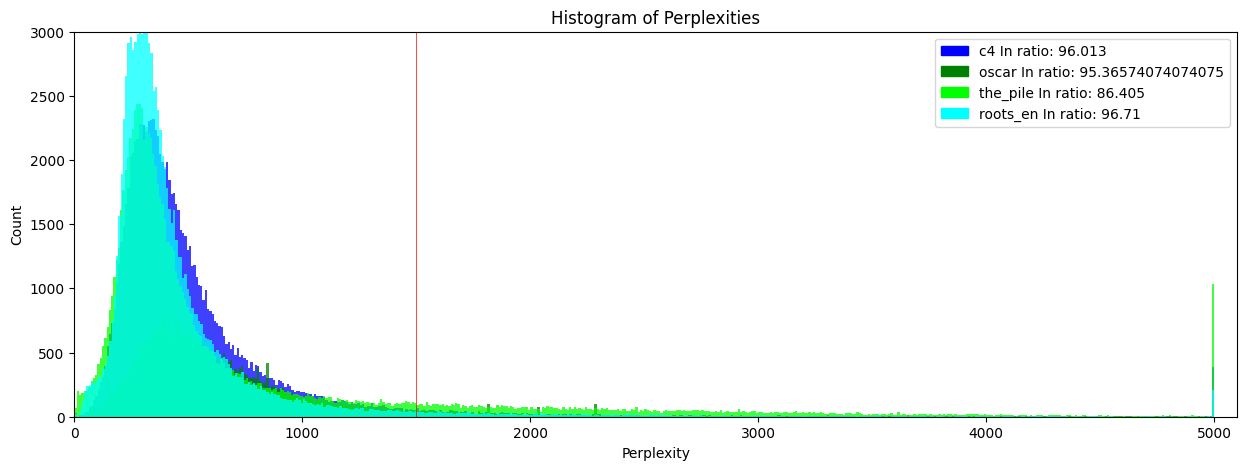

In [22]:
plot_perplexity_histogram()

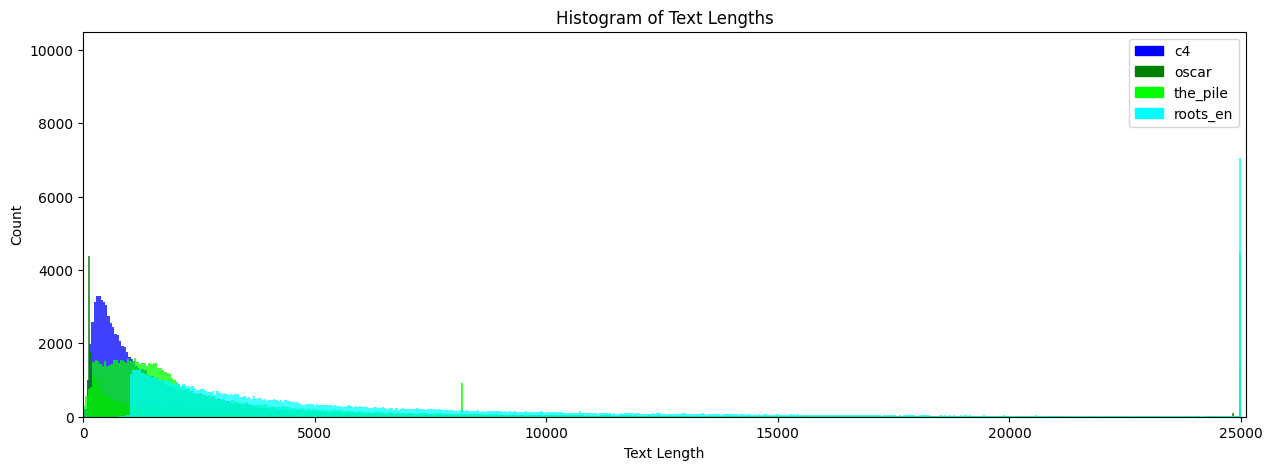

In [23]:
plot_text_length_histogram()

/tmp/ipykernel_5014/864003242.py:17: RuntimeWarning: divide by zero encountered in true_divide
  y = 590 + 10000 / np.cbrt(x)
/tmp/ipykernel_5014/864003242.py:22: RuntimeWarning: divide by zero encountered in true_divide
  y2 = 590 - 10000 / np.cbrt(x)


<module 'matplotlib.pyplot' from '/home/piktus_huggingface_co/anaconda3/envs/lumi/lib/python3.10/site-packages/matplotlib/pyplot.py'>

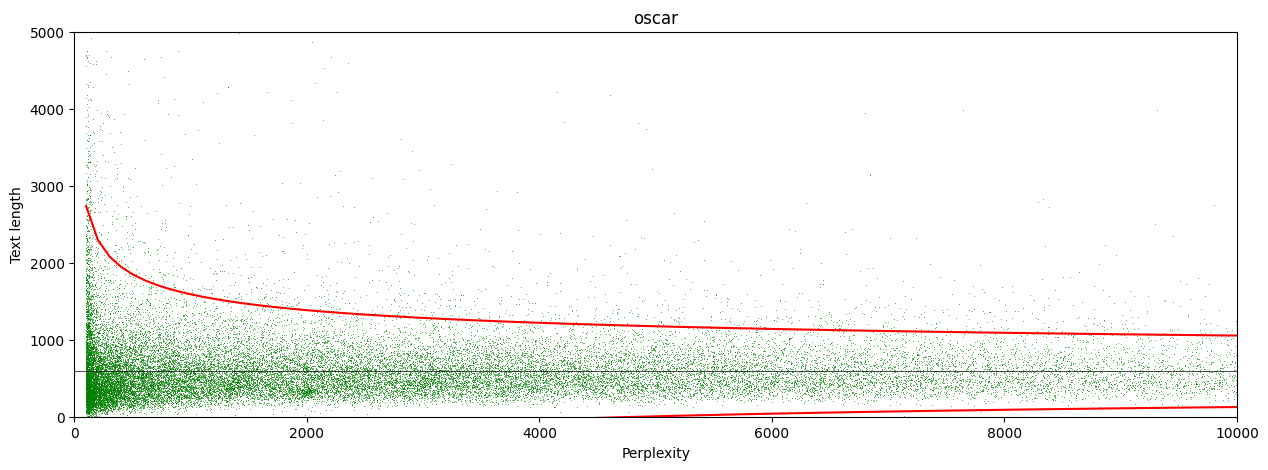

In [24]:
plot_simple("oscar")

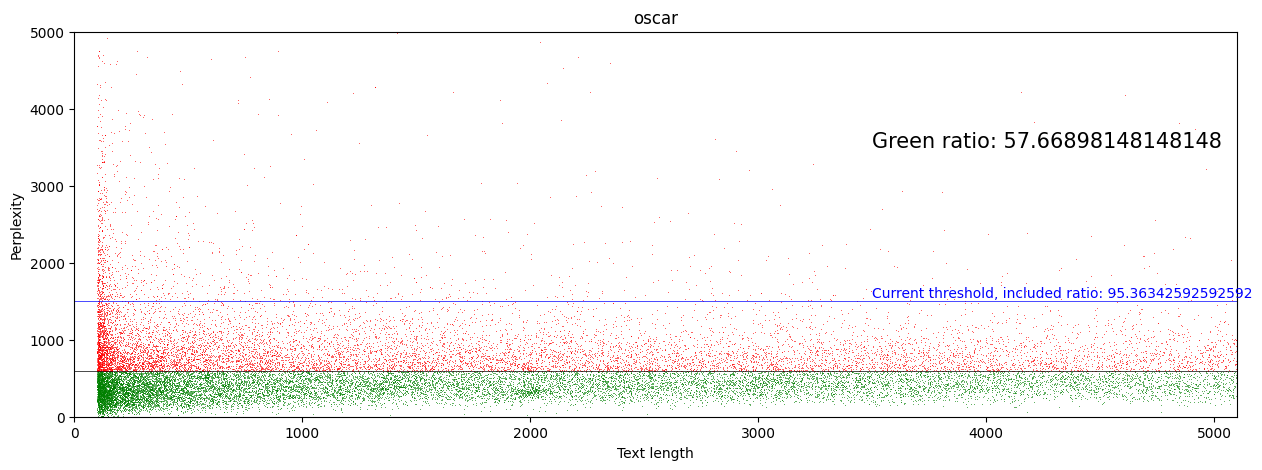

In [25]:
oscar_cutoff = 590
plt_base = plot_full("oscar", oscar_cutoff)

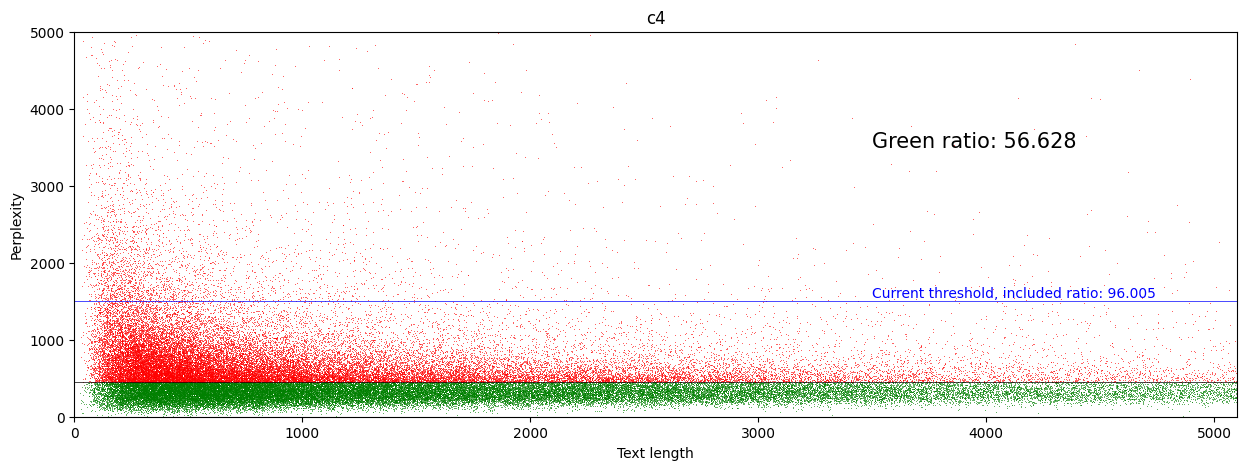

In [26]:
c4_cutoff = 451
plt_base = plot_full("c4", c4_cutoff)

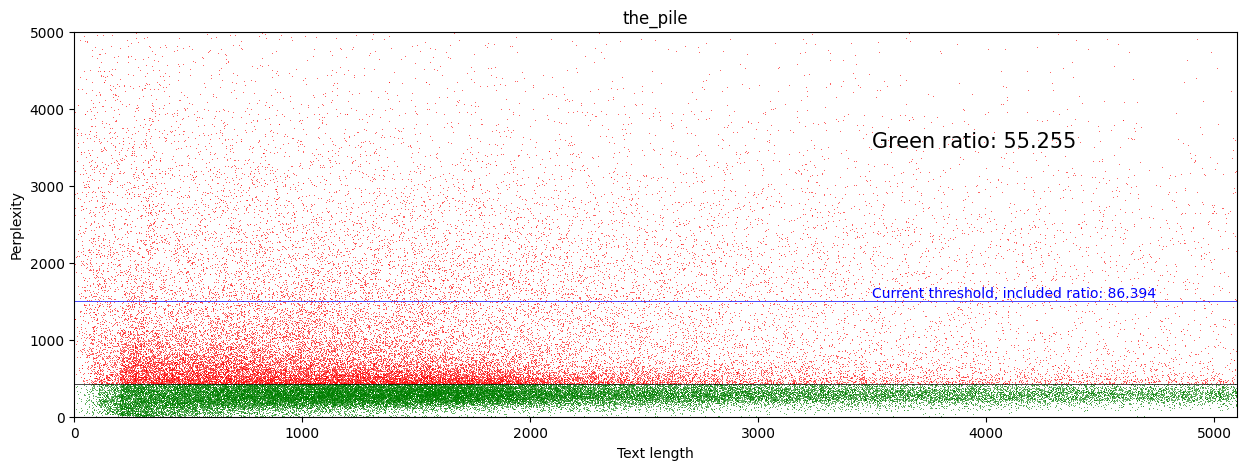

In [27]:
the_pile_cutoff = 431
plt_base = plot_full("the_pile", the_pile_cutoff)

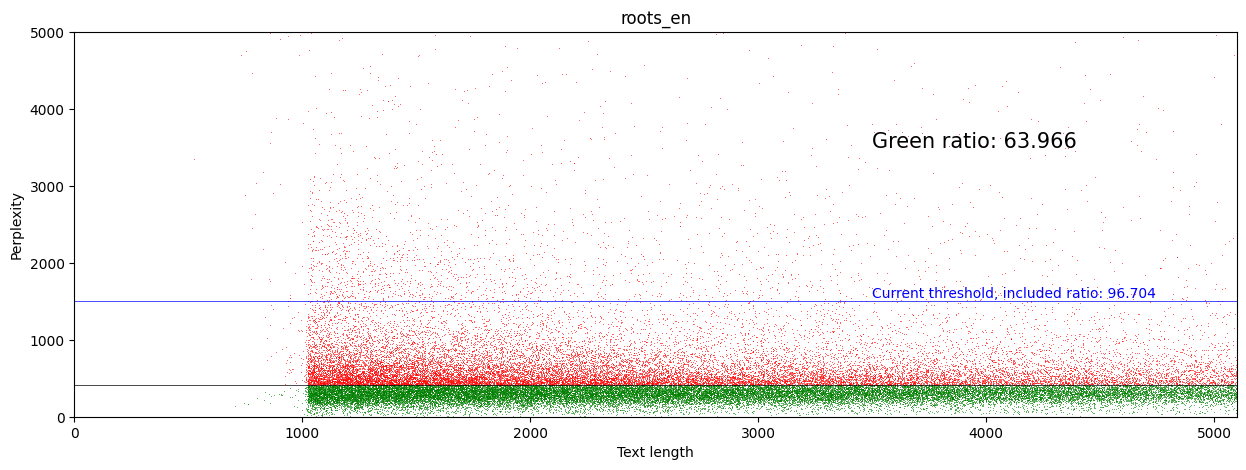

In [28]:
roots_en_cutoff = 415
plt_base = plot_full("roots_en", roots_en_cutoff)

fixed length (eg max 1024 or whatever) randomly sampled spans in larger documents to compute the perplexity and plot the perplexity versus total text length to see if the convergence to ~400 still hold?

In [29]:
def find_whitespace(text):
    for i, c in enumerate(text):
        if c in string.whitespace:
            yield i


def get_segmentation(text, passage_tokens, overlap_tokens):
    whitespace_idx = [-1] + list(find_whitespace(text))
    unique_tokens = passage_tokens - overlap_tokens
    passages = []
    for i in range(0, len(whitespace_idx), unique_tokens):
        if i + passage_tokens >= len(whitespace_idx):
            passages.append((whitespace_idx[i] + 1, len(text)))
            break
        passages.append((whitespace_idx[i] + 1, whitespace_idx[i + passage_tokens] + 1))
    return passages


def remove_non_printing_characters(document, non_printing_characters_re):
    return non_printing_characters_re.sub("", document)


def uniform_whitespace(
    document,
    whitespace=[
        " ",
        " ",
        " ",
        " ",
        " ",
        "　",
        " ",
        " ",
        " ",
        " ",
        "￼",
        "",
    ],
):
    """There are different whitespace characters."""
    whitespace = "".join(whitespace + list(string.whitespace))
    whitespace = set(whitespace)
    document = "".join([char if char not in whitespace else " " for char in document])
    return document


def replace_digits_with_zeros(document, digits_re):
    return digits_re.sub("0", document)


def replace_unicode_punctuation(document, unicode_punctuation):
    return "".join(unicode_punctuation.get(c, c) for c in document)


def tokenization(document, sentencepiece_model, join_on_whitespace):
    document_tokenized = sentencepiece_model.encode_as_pieces(document)
    if join_on_whitespace:
        document_tokenized = " ".join(document_tokenized)
    return document_tokenized


def normalization(
    document,
    remove_non_printing_characters_cond,
    strip,
    lower_case,
    uniform_whitespace_cond,
    replace_digits_with_zeros_cond,
    replace_unicode_punctuation_cond,
    non_printing_characters_re,
    digits_re,
    unicode_punctuation,
):
    if remove_non_printing_characters_cond:
        document = remove_non_printing_characters(document, non_printing_characters_re)
    if strip:
        document = document.strip()
    if not document:
        return document
    if lower_case:
        document = document.lower()
    if uniform_whitespace_cond:
        document = uniform_whitespace(document)
    if replace_digits_with_zeros_cond:
        document = replace_digits_with_zeros(document, digits_re)
    if replace_unicode_punctuation_cond:
        document = replace_unicode_punctuation(document, unicode_punctuation)
    return document

In [30]:
def load_sentencepiece_model(path_sentencepiece_model):
    sentencepiece_model = sentencepiece.SentencePieceProcessor()
    sentencepiece_model.load(path_sentencepiece_model)
    return sentencepiece_model


def load_kenlm_model(path_kenlm_model):
    kenlm_model = kenlm.Model(path_kenlm_model)
    return kenlm_model

In [35]:
sentencepiece_model = load_sentencepiece_model("/mnt/disks/looking_glass_storage/lumi/kenlm/en.sp.model")

In [36]:
kenlm_model = load_kenlm_model("/mnt/disks/looking_glass_storage/lumi/kenlm/en.arpa.bin")

In [37]:
non_printing_characters_re = re.compile(f"[{''.join(map(chr, list(range(0,32)) + list(range(127,160))))}]")

digits_re: re.Pattern = re.compile(r"\d")

unicode_punctuation = {
    "，": ",",
    "。": ".",
    "、": ",",
    "„": '"',
    "”": '"',
    "“": '"',
    "«": '"',
    "»": '"',
    "１": '"',
    "」": '"',
    "「": '"',
    "《": '"',
    "》": '"',
    "´": "'",
    "∶": ":",
    "：": ":",
    "？": "?",
    "！": "!",
    "（": "(",
    "）": ")",
    "；": ";",
    "–": "-",
    "—": " - ",
    "．": ". ",
    "～": "~",
    "’": "'",
    "…": "...",
    "━": "-",
    "〈": "<",
    "〉": ">",
    "【": "[",
    "】": "]",
    "％": "%",
    "►": "-",
}

In [38]:
def compute_perplexity_score(document, sentencepiece_model=sentencepiece_model, kenlm_model=kenlm_model):
    document = normalization(
        document=document,
        remove_non_printing_characters_cond=True,
        strip=True,
        lower_case=False,
        uniform_whitespace_cond=True,
        replace_digits_with_zeros_cond=True,
        replace_unicode_punctuation_cond=True,
        non_printing_characters_re=non_printing_characters_re,
        digits_re=digits_re,
        unicode_punctuation=unicode_punctuation,
    )
    document = tokenization(document, sentencepiece_model, join_on_whitespace=True)
    doc_log_score, doc_length = 0, 0
    for line in document.split("\n"):
        log_score = kenlm_model.score(line)
        length = len(line.split()) + 1
        doc_log_score += log_score
        doc_length += length
    pp_score = 10.0 ** (-doc_log_score / doc_length)
    pp_score = round(pp_score, 1)
    return pp_score

In [39]:
max_length = 1024
passage_tokens = 256

In [40]:
def choose_passage(row, max_length=max_length, passage_tokens=passage_tokens):
    if row["text_length"] > max_length:
        segments = get_segmentation(row["text"], passage_tokens=passage_tokens, overlap_tokens=0)
        left, right = random.choice(segments)
        return row["text"][left:right]
    return row["text"]

In [41]:
for dataset_name, ds_df in datasets.items():
    print(dataset_name)
    ds_df["passage"] = ds_df.apply(
        lambda doc: choose_passage(doc, max_length=max_length, passage_tokens=passage_tokens),
        axis=1,
    )
    ds_df["passage_length"] = ds_df.apply(lambda doc: len(doc["passage"]), axis=1)
    ds_df["passage_perplexity"] = ds_df.swifter.apply(
        lambda doc: int(compute_perplexity_score(doc["passage"])),
        axis=1,
    )
    ds_df["passage_perplexity_clipped"] = ds_df.apply(
        lambda doc: doc["passage_perplexity"]
        if doc["passage_perplexity"] < perplexity_cutoff
        else perplexity_cutoff,
        axis=1,
    )

c4


Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

oscar


Pandas Apply:   0%|          | 0/43200 [00:00<?, ?it/s]

the_pile


Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

roots_en


Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

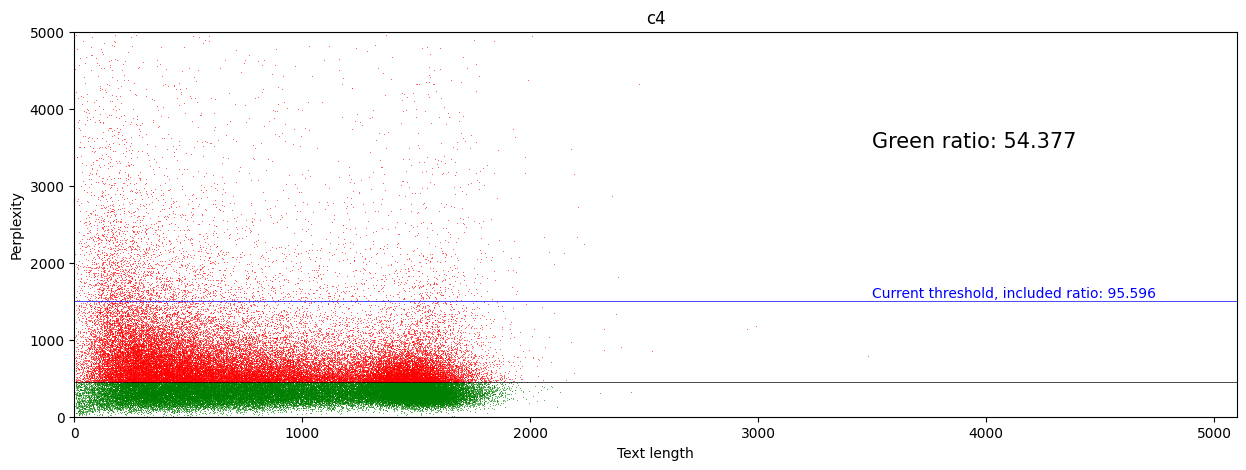

<module 'matplotlib.pyplot' from '/home/piktus_huggingface_co/anaconda3/envs/lumi/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [42]:
plot_full("c4", c4_cutoff, perplexity_key="passage_perplexity", length_key="passage_length")

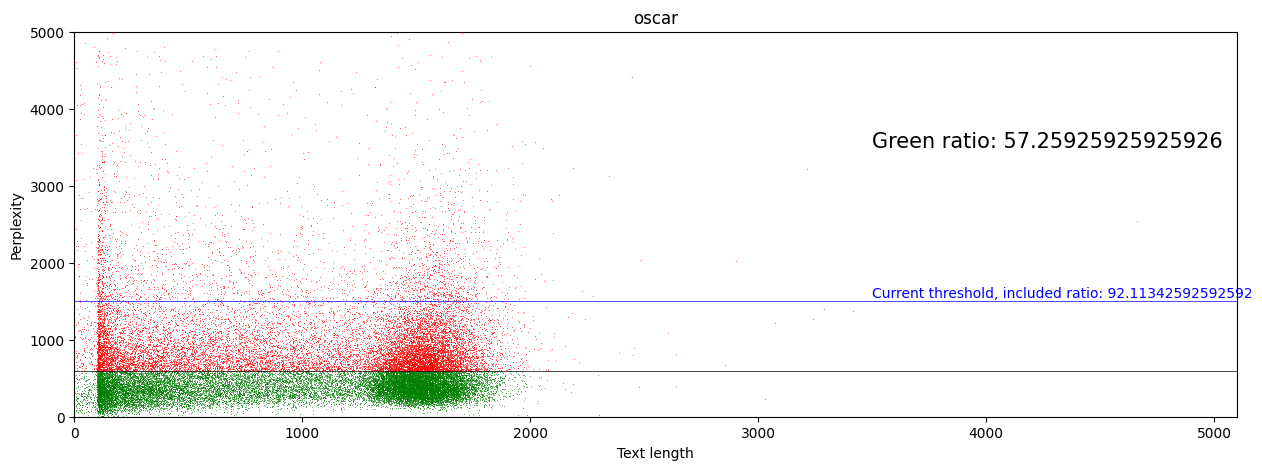

<module 'matplotlib.pyplot' from '/home/piktus_huggingface_co/anaconda3/envs/lumi/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [43]:
plot_full("oscar", oscar_cutoff, perplexity_key="passage_perplexity", length_key="passage_length")

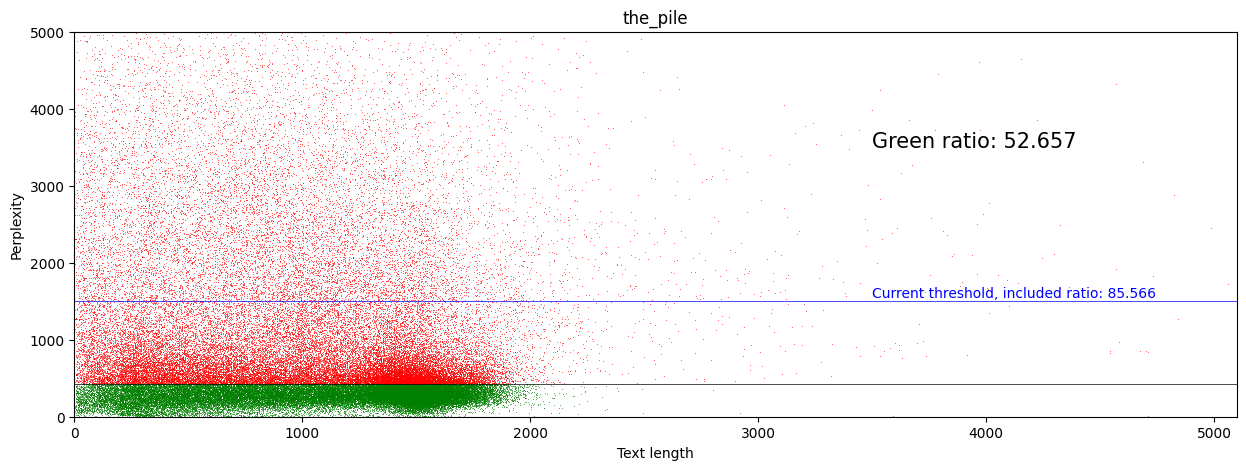

<module 'matplotlib.pyplot' from '/home/piktus_huggingface_co/anaconda3/envs/lumi/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [44]:
plot_full("the_pile", the_pile_cutoff, perplexity_key="passage_perplexity", length_key="passage_length")

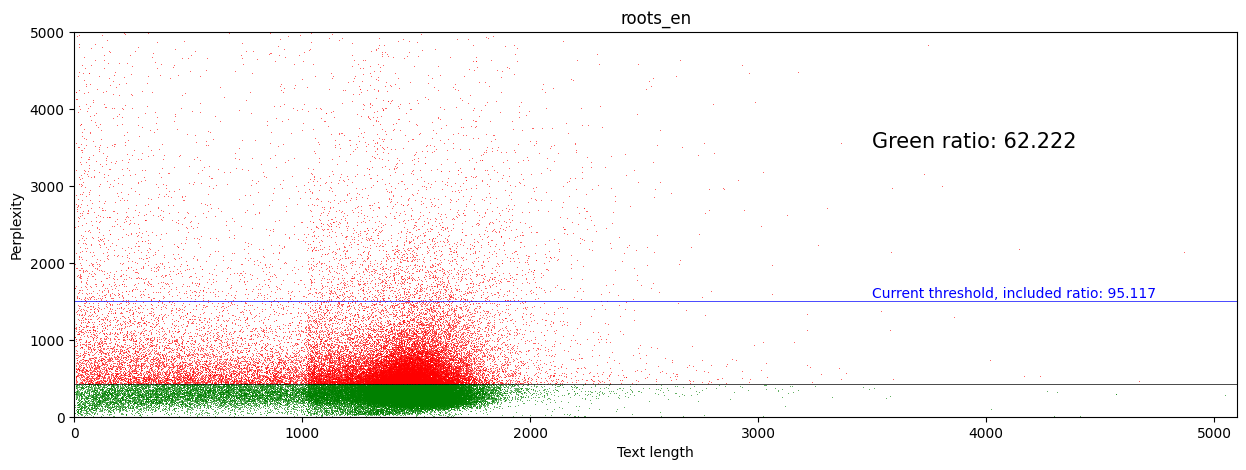

<module 'matplotlib.pyplot' from '/home/piktus_huggingface_co/anaconda3/envs/lumi/lib/python3.10/site-packages/matplotlib/pyplot.py'>

In [45]:
plot_full("roots_en", the_pile_cutoff, perplexity_key="passage_perplexity", length_key="passage_length")

In [46]:
def get_max_perplexity(doc):
    segments = get_segmentation(doc["text"], passage_tokens=1024, overlap_tokens=0)
    passages = [doc["text"][left:right] for left, right in segments]
    perplexities = [int(compute_perplexity_score(passage)) for passage in passages]
    return max(perplexities)


def get_min_perplexity(doc):
    segments = get_segmentation(doc["text"], passage_tokens=1024, overlap_tokens=0)
    passages = [doc["text"][left:right] for left, right in segments]
    perplexities = [int(compute_perplexity_score(passage)) for passage in passages]
    return min(perplexities)

In [ ]:
for dataset_name, ds_df in datasets.items():
    print(dataset_name)
    ds_df["max_perplexity"] = ds_df.swifter.apply(lambda doc: get_max_perplexity(doc), axis=1)
    ds_df["min_perplexity"] = ds_df.swifter.apply(lambda doc: get_min_perplexity(doc), axis=1)
    ds_df["max_perplexity_clipped"] = ds_df.apply(
        lambda doc: doc["max_perplexity"] if doc["max_perplexity"] < perplexity_cutoff else 2 * perplexity_cutoff,
        axis=1,
    )
    ds_df["min_perplexity_clipped"] = ds_df.apply(
        lambda doc: doc["min_perplexity"] if doc["min_perplexity"] < perplexity_cutoff else 2 * perplexity_cutoff,
        axis=1,
    )

c4


Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

oscar


Pandas Apply:   0%|          | 0/43200 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/43200 [00:00<?, ?it/s]

the_pile


Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

roots_en


Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

In [ ]:
plot_perplexity_histogram(bins=1000, ylim=5000)

In [ ]:
plot_perplexity_histogram(perplexity_key="max_perplexity_clipped", bins=1000, ylim=5000)

In [ ]:
plot_perplexity_histogram(perplexity_key="min_perplexity_clipped", bins=1000, ylim=5000)

In [ ]:
plot_perplexity_histogram(perplexity_key="passage_perplexity_clipped", bins=1000, ylim=5000)

In [ ]:
plot_text_length_histogram()

In [ ]:
datasets["oscar"]

In [ ]:
datasets["oscar"][datasets["oscar"]["max_perplexity"] != datasets["oscar"]["min_perplexity"]]

In [ ]:
datasets["oscar"][datasets["oscar"]["perplexity_score"] < datasets["oscar"]["min_perplexity"]]

In [ ]:
datasets["oscar"][datasets["oscar"]["perplexity_score"] > datasets["oscar"]["max_perplexity"]]

In [ ]:
get_max_perplexity(datasets["oscar"].iloc[99997])

In [43]:
datasets["oscar"].iloc[99997]["text"]

'All $200,000 $250,000 $300,000 $350,000 $400,000 $450,000 $500,000 $550,000 $600,000 $650,000 $700,000 $750,000 $800,000 $850,000 $900,000 $950,000 $1,000,000 $2,000,000 $3,000,000 $4,000,000 $5,000,000\nAll $200,000 $250,000 $300,000 $350,000 $400,000 $450,000 $500,000 $550,000 $600,000 $650,000 $700,000 $750,000 $800,000 $850,000 $900,000 $950,000 $1,000,000 $2,000,000 $3,000,000 $4,000,000 $5,000,000+'

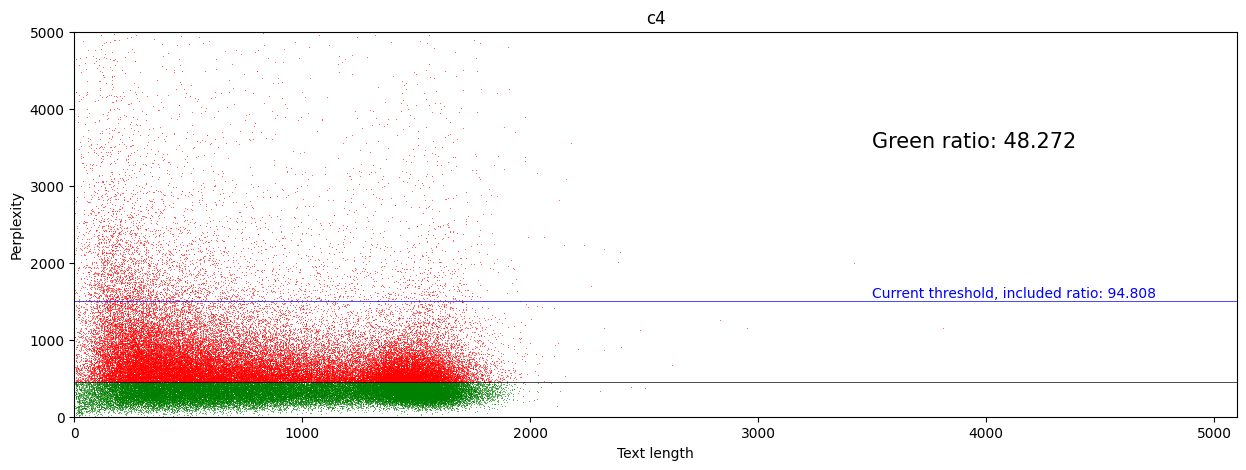

<module 'matplotlib.pyplot' from '/home/piktus_huggingface_co/anaconda3/envs/lumi/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [44]:
plot_full("c4", c4_cutoff, perplexity_key="passage_perplexity", length_key="passage_length")

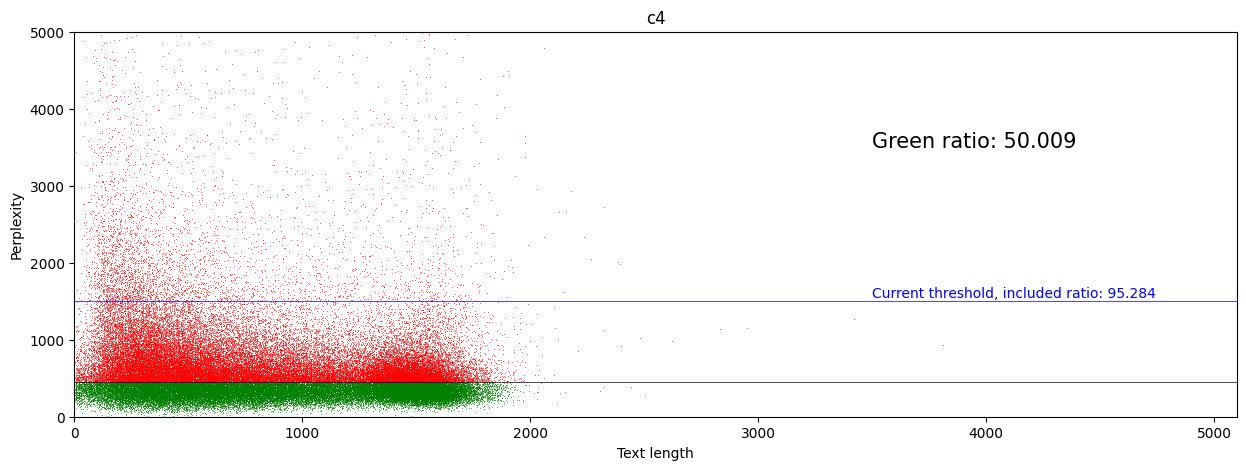

<module 'matplotlib.pyplot' from '/home/piktus_huggingface_co/anaconda3/envs/lumi/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [45]:
plot_full("c4", c4_cutoff, perplexity_key="perplexity_score", length_key="passage_length")

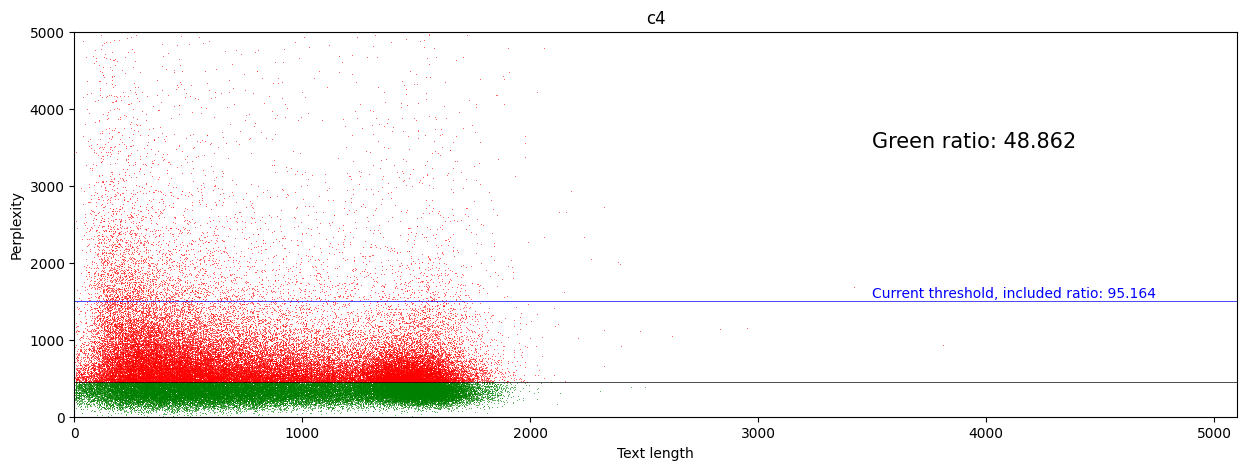

<module 'matplotlib.pyplot' from '/home/piktus_huggingface_co/anaconda3/envs/lumi/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [46]:
plot_full("c4", c4_cutoff, perplexity_key="max_perplexity", length_key="passage_length")

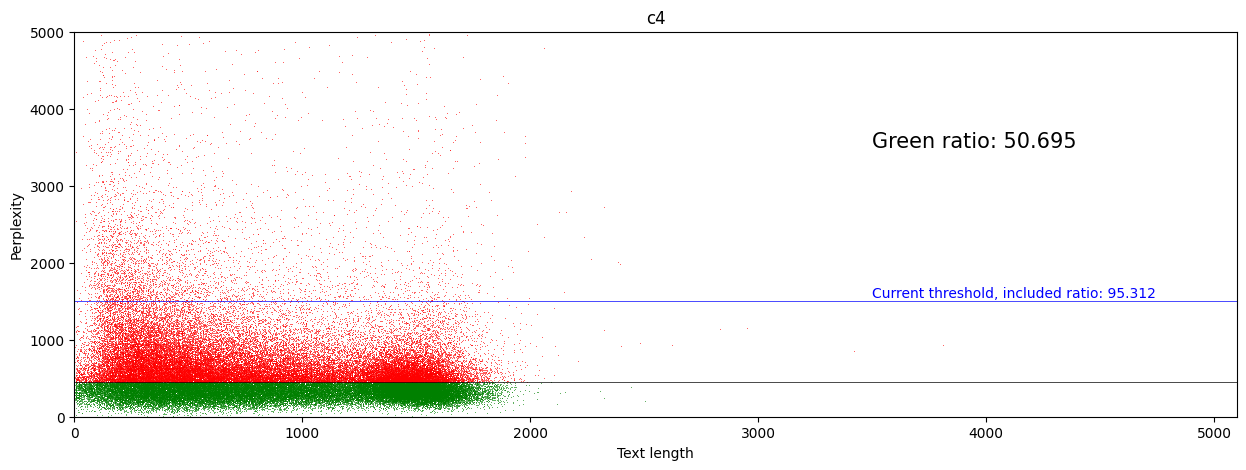

<module 'matplotlib.pyplot' from '/home/piktus_huggingface_co/anaconda3/envs/lumi/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [47]:
plot_full("c4", c4_cutoff, perplexity_key="min_perplexity", length_key="passage_length")

In [76]:
datasets["oscar"].iloc[99998]["text"]

'ï¿½ï¿½\x11à¡±\x1aï¿½>\x03ï¿½ï¿½\t\x06\x01o\x10r\x01ï¿½ï¿½ï¿½ï¿½nï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿½ï¿

In [79]:
compute_perplexity_score(datasets["oscar"].iloc[99998]["text"])

283449.9

In [91]:
compute_perplexity_score(datasets["oscar"].iloc[99998]["text"][-26748:])

283292.0

In [81]:
compute_perplexity_score(datasets["oscar"].iloc[99998]["text"][-200:])

235222.2

In [82]:
compute_perplexity_score(datasets["oscar"].iloc[99998]["text"][-300:])

372167.4

In [83]:
compute_perplexity_score(datasets["oscar"].iloc[99998]["text"][-406:])

475299.1

In [84]:
compute_perplexity_score(datasets["oscar"].iloc[99998]["text"][-500:])

519143.0

In [85]:
compute_perplexity_score(datasets["oscar"].iloc[99998]["text"][-600:])

553777.1

In [86]:
compute_perplexity_score(datasets["oscar"].iloc[99998]["text"][-500:])

519143.0

In [87]:
len(datasets["oscar"].iloc[99998]["text"])

26749

In [92]:
sample = datasets["oscar"].iloc[99998]["text"]

In [99]:
x = []
for i in tqdm(range(len(sample))):
    x.append(compute_perplexity_score(sample[i:]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26749/26749 [04:11<00:00, 106.41it/s]


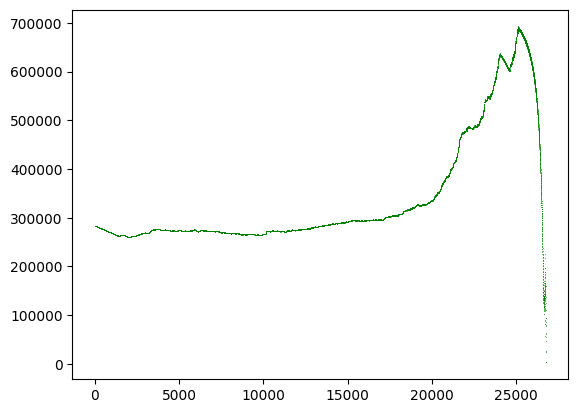

In [100]:
plt.scatter(range(len(sample)), x, marker=".", s=1, color="g", linewidths=0)
plt.show()

In [102]:
y = []
for i in tqdm(range(len(sample))):
    y.append(compute_perplexity_score(sample[0:i]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26749/26749 [03:58<00:00, 112.17it/s]


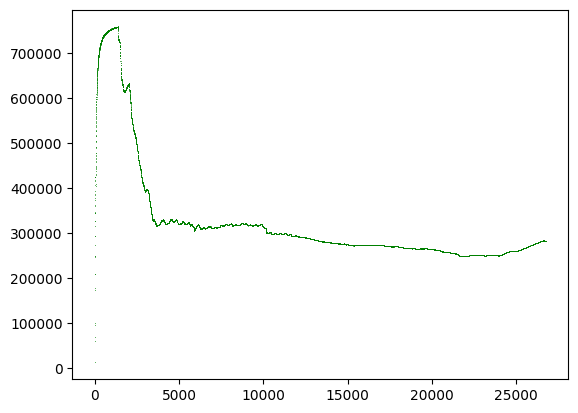

In [103]:
plt.scatter(range(len(sample)), y, marker=".", s=1, color="g", linewidths=0)
plt.show()